In [1]:
from datetime import datetime
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
import plotly.express as px
import plotly


import sklearn
from sklearn.manifold import TSNE, Isomap

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import (KMeans, SpectralClustering, 
                             MiniBatchKMeans, AgglomerativeClustering)

from sklearn.metrics import (davies_bouldin_score, 
                            silhouette_score,
                            calinski_harabasz_score,
                            homogeneity_score)

from utils.portfolio import MarkowitzPortfolio, backtesting_universal
from utils.portfolio_metrics import (calculate_measures, show_drawdown_recovery, 
                                     find_max_recovery, find_max_drawdown)

from utils.pipeline import (general_pipeline, calc_metrics, clustering_estimation, 
                            backtesting_one_model, select_assets, clustering_estimation, get_clusters)

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('config/config.json', 'r') as file:
    config = json.load(file)
    
with open('config/config_emb_path.json', 'r') as file:
    config_emb = json.load(file)
    
rs = config['random_state']

# data loading

In [3]:
df_original = pd.read_csv(config['ticker_data_close'], index_col=0)

df_na = df_original.isna().sum()
thresh = 0.05 * len(df_original)
stocks_to_drop = df_na[df_na > thresh].index.tolist()
df_original = df_original.drop(stocks_to_drop, axis=1)
df_original = df_original.dropna(axis=0)

df_original.index = pd.to_datetime(df_original.index)
df_original_train = df_original[(df_original.index < datetime(2020, 1, 1)) ]
df_original_train.tail()

,CMCSA,LVS,EXC,GPN,MSFT,ALL,VTR,NXPI,COST,DRI,...,CERN,A,STT,EA,KO,MDLZ,HRL,AMP,MET,MCHP
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,44.529999,69.290001,32.325249,182.839996,157.380005,111.169998,57.369999,129.199997,294.230011,108.500000,...,499.640015,85.300003,79.639999,108.550003,54.709999,54.990002,45.349998,167.720001,50.990002,52.525002
2019-12-26,44.970001,69.940002,32.325249,183.490005,158.669998,111.599998,57.610001,128.679993,295.730011,108.910004,...,503.239990,85.449997,79.849998,108.510002,55.020000,54.849998,45.299999,167.679993,51.240002,52.965000
2019-12-27,45.099998,69.739998,32.389442,182.889999,158.960007,111.870003,57.830002,128.190002,294.109985,108.010002,...,503.010010,85.419998,80.120003,108.430000,55.349998,55.279999,45.259998,166.710007,50.830002,52.740002
2019-12-30,45.180000,69.300003,32.368046,181.350006,157.589996,111.769997,57.980000,127.550003,295.140015,108.959999,...,500.839996,84.900002,79.879997,106.930000,55.270000,55.000000,45.000000,166.070007,50.700001,52.494999
2019-12-31,44.970001,69.040001,32.517834,182.559998,157.699997,112.449997,57.740002,127.260002,293.920013,109.010002,...,502.700012,85.309998,79.099998,107.510002,55.349998,55.080002,45.110001,166.580002,50.970001,52.360001


In [4]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
print(df.shape)
df.head()

(482, 1196)


,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,sector
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011652,...,-0.019737,-0.012955,-0.016524,-0.007316,-0.009475,-0.005723,0.017351,-0.007921,-0.009695,Healthcare
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,-0.016889,-0.052971,-0.039305,-0.039339,-0.028665,0.034570,0.039120,-0.039216,-0.017143,Industrials
AAP,0.009049,0.036899,0.010631,-0.007042,-0.008080,0.000905,0.021340,0.026472,-0.017595,0.012730,...,-0.013735,-0.002231,-0.008399,-0.021997,-0.017570,0.010337,0.025171,-0.022410,-0.020794,Consumer Cyclical
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000115,-0.000229,0.005680,0.010326,-0.005082,0.016516,...,0.015665,-0.020268,-0.006375,-0.015124,0.002260,0.006566,-0.012652,-0.049119,-0.030039,Technology
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007538,-0.005487,-0.004213,0.010779,0.021427,0.018246,...,-0.006239,-0.010298,0.019243,0.000350,-0.012932,0.003612,0.020322,-0.013001,-0.059627,Healthcare


In [5]:
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)

tickers_list = df_pct.columns.tolist()

df_pct.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,0.012406,...,-0.010834,-0.006693,0.019640,-0.003426,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,-0.001094,...,0.005415,-0.007791,0.001384,-0.000149,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
2018-01-05,0.015988,-0.000380,0.010631,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,0.004053,...,0.006671,-0.007003,-0.000806,0.014051,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,0.001745,...,-0.013314,0.007480,0.004496,0.006781,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011996
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.009432,0.001700,0.003335,-0.002069,...,0.006778,-0.011667,-0.004246,-0.041728,0.000288,-0.002651,-0.016083,0.030643,0.023509,0.011719


In [6]:
df_pct_train = df_pct[(df_pct.index < datetime(2020, 1, 1)) ]

<AxesSubplot:xlabel='Date'>

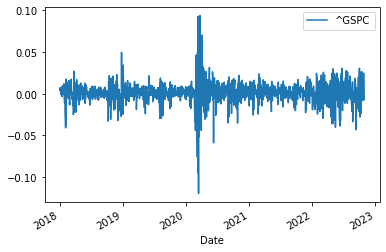

In [7]:
df_market = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market.plot()

In [8]:
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
df_sectors = df_sectors.sort_values('ticker')
df_sectors.head()

,ticker,sector
287,A,Healthcare
462,AAL,Industrials
401,AAP,Consumer Cyclical
99,AAPL,Technology
267,ABBV,Healthcare


In [9]:
tickers = df.index.tolist()

In [10]:
# feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
# df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'sector':df['sector']})

# fig = px.scatter(df_tsne, x = 'axis0', y = 'axis1', color="sector", width=800, height=600)
# fig.show()

# Experiments

In [11]:
def custom_score_clustering_gridsearch(estimator, X, y=None):
    estimator.fit(X)
    labels_predicted = estimator.labels_
    score = silhouette_score(X, labels_predicted)
    return score

def selection_sharp(list_tickers, n_save, df_pct, riskfree_rate):
    df_pct = df_pct[list_tickers]
    
    sharp = (df_pct.mean() - riskfree_rate)/df_pct.std()
    selected_tickers = sharp.sort_values(ascending=False).head(n_save).index.tolist()
    
    return selected_tickers

# embeddings

In [12]:
emb_dict = dict()

# for name, path in config_emb.items():
#     emb_dict[name] = pd.read_csv(path, index_col=0).values

top_path = "data/embeddings"
all_files = os.listdir(top_path)

for emb_path in all_files:
    
    emb_name = emb_path.replace('.csv', '')
    emb_path = top_path + '/' + emb_path
    
    emb_dict[emb_name] = pd.read_csv(emb_path, index_col=0).values

In [13]:
for method_name, data in emb_dict.items():
    print(method_name, np.sum(np.isnan(data)), data.shape)

ts2vec 0 (482, 100)
takens_one_BC_2 0 (482, 100)
transformer 0 (482, 100)
takens_one_PL_2 0 (482, 100)
takens_mult_PI_0_sigma=0.0005 0 (482, 100)
takens_mult_PL_2 0 (482, 100)
takens_one_BC_1 0 (482, 100)
table_finance_features 0 (482, 14)
takens_mult_PI_1_sigma=0.0005 0 (482, 100)
autoencoder_mlp 0 (482, 100)
takens_mult_PL_1 0 (482, 100)
tsfresh 0 (482, 100)
takens_one_BC_0 0 (482, 100)
pca 0 (482, 100)
takens_one_PI_0_sigma=0.0005 0 (482, 100)
autoencoder_conv 0 (482, 100)
takens_mult_BC_0 0 (482, 100)
takens_one_PI_2_sigma=0.0005 0 (482, 100)
takens_one_PI_1_sigma=0.0005 0 (482, 100)
takens_mult_PI_2_sigma=0.0005 0 (482, 100)
fastica 0 (482, 100)
takens_mult_BC_2 0 (482, 100)
takens_one_PL_1 0 (482, 100)
autoencoder_lstm 0 (482, 100)
takens_mult_BC_1 0 (482, 100)


# pipeline

In [14]:
riskfree = config['riskless_rate']
riskfree_rate=(1 + riskfree) **(1/252) - 1,
ret_det=(1 + 0.03) **(1/252) - 1,
    
    
clust_params = {'clust_model':KMeans(n_clusters=config['n_clusters'], random_state=rs),
                'make_grid':False, 
                'grid_params':{
                   'n_clusters':np.arange(9, 14),
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
                },
                'grid_metric':custom_score_clustering_gridsearch}


selection_params = {'selection_method':selection_sharp,
                    'n_save':2, 
                    'riskfree_rate':riskfree_rate,}

backtesting_params = {'port_model':MarkowitzPortfolio,
                      'window_train':24, # size of train window in months
                      'window_test':1,  # size of train window in months
                       
                      'train_start_year':2018, #start data year
                      'train_start_month':1, #start data month 
                      'test_finish_year':2022, #end data year
                      'test_finish_month':11, #end data month
                      'ret_det':ret_det
                     }

In [ ]:
cluster_metrics_df = pd.DataFrame() 
port_df = pd.DataFrame()    #Считаем портфель Марковица для всех методов кластеризации
dict_weight_methods = dict()
financial_metrics = pd.DataFrame() 


for model_name, embedding_data in tqdm(emb_dict.items()):
    
    weights_all, return_portfolio, cluster_metrics, fin_metrics = general_pipeline(
        df_pct,
        df_market,
        df_sectors, 
        embedding_data=embedding_data,
        clust_params=clust_params,
        selection_params=selection_params,
        backtesting_params=backtesting_params)
    
    cluster_metrics_df[model_name] = cluster_metrics
    port_df[model_name] = return_portfolio
    dict_weight_methods[model_name] = weights_all
    financial_metrics[model_name] = fin_metrics

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
financial_metrics

In [ ]:
cluster_metrics_df

### tslearn clustering

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape

In [ ]:
# tslearn_models = {'KShape' : KShape(n_clusters=config['n_clusters'], n_init=1, random_state=rs),
#                   'TimeSeriesKMeans' : TimeSeriesKMeans(n_clusters=config['n_clusters'], metric="dtw", 
#                                                         random_state=rs, n_jobs=4),
#                  }


# tslearn_params = {
#     'TimeSeriesKMeans' : {
#                    'n_clusters':np.arange(9, 14),
#                    'init': ['k-means++', 'random'],
#                    'algorithm':['auto', 'full', 'elkan']
#                 },

#     'KShape' : {
#                    'n_clusters':np.arange(9, 14),
#                    'init': ['k-means++', 'random'],
#                    'algorithm':['auto', 'full', 'elkan']
#                 }
    
# }

# clust_params = {#'clust_model':KMeans(n_clusters=11, random_state=42),
#                 'make_grid':False, 
# #                 'grid_params':{
# #                    'n_clusters':np.arange(9, 14),
# #                    'init': ['k-means++', 'random'],
# #                    'algorithm':['auto', 'full', 'elkan']
# #                 },
#                 'grid_metric':custom_score_clustering_gridsearch}

# for model_name, model in tqdm(tslearn_models.items()):
#     clust_params['clust_model'] = model
#     clust_params['grid_params'] = tslearn_params[model_name]
    
#     weights_all, return_portfolio, cluster_metrics, fin_metrics = general_pipeline(
#         df_pct,
#         df_market,
#         df_sectors, 
#         embedding_data=df_original_train.T.values,
#         clust_params=clust_params,
#         selection_params=selection_params,
#         backtesting_params=backtesting_params)
    
#     cluster_metrics_df['tsclust_'+model_name] = cluster_metrics
#     port_df['tsclust_'+model_name] = return_portfolio
#     dict_weight_methods['tsclust_'+model_name] = weights_all
#     financial_metrics['tsclust_'+model_name] = fin_metrics

### benchmarks

In [ ]:
#port_df['sp500'] = df_market.loc[port_df.index] 
financial_metrics['sectors'] = calc_metrics(df_market.loc[port_df.index] .copy(), df_market, 
                                            riskfree_rate=riskfree_rate)

# economic sectors
clust_econ_sectors = LabelEncoder().fit_transform(df['sector'])
df_clusters = pd.DataFrame([tickers_list, clust_econ_sectors], index=['ticker', 'cluster']).T


selected_tickers = select_assets(df_clusters, df_pct, **selection_params)
df_pct_loc = df_pct[selected_tickers]
weights_all, return_portfolio = backtesting_one_model(df_pct_loc, # df with pct_changes: columns - tick, index - date
                    **backtesting_params)


cluster_metrics_df['sectors'] = clustering_estimation(df_pct.T.values, df_clusters, df_sectors)
dict_weight_methods['sectors'] = weights_all
port_df['sectors'] = return_portfolio
financial_metrics['sectors'] = calc_metrics(return_portfolio.copy(), df_market, riskfree_rate=riskfree_rate)

# results estimation

In [ ]:
financial_metrics = financial_metrics.T
financial_metrics.sort_values('Sharpe', ascending=False)

In [ ]:
cluster_metrics_df = cluster_metrics_df.T
cluster_metrics_df.sort_values(['Sil'], ascending=False)